In [1]:
# Cell 6a: Set CUDA_LAUNCH_BLOCKING for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [2]:
# Cell 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Using device: cpu


In [3]:
# Cell 2: Load Fashion-MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 26421880/26421880 [00:01<00:00, 18628729.16it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 307940.57it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5558995.98it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5082927.73it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# Cell 3: Define the Encoder and Decoder for Basic VAE
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_logvar = nn.Linear(400, 20)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h1 = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 28*28)

    def forward(self, z):
        h1 = torch.relu(self.fc1(z))
        x_reconstructed = torch.sigmoid(self.fc2(h1))
        return x_reconstructed.view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [5]:
# Cell 4: Ensure shapes are compatible in loss function
def loss_function(reconstructed_x, x, mu, logvar):
    reconstructed_x = reconstructed_x.view(x.size())  # Ensure the shapes match
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
# Cell 5: Updated Training Loop with Explicit Device Setting
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Ensure data is on the correct device

        optimizer.zero_grad()
        try:
            reconstructed_batch, mu, logvar = model(data)
        except RuntimeError as e:
            print(f"RuntimeError during forward pass: {e}")
            print(f"Data shape: {data.shape}, Data type: {data.dtype}")
            continue

        # Debugging: Check the shapes and types of tensors
        print(f"Batch {batch_idx}:")
        print(f"data.shape: {data.shape}, reconstructed_batch.shape: {reconstructed_batch.shape}")
        print(f"data.dtype: {data.dtype}, reconstructed_batch.dtype: {reconstructed_batch.dtype}")

        try:
            loss = loss_function(reconstructed_batch, data, mu, logvar)
        except RuntimeError as e:
            print(f"RuntimeError during loss computation: {e}")
            print(f"reconstructed_batch.shape: {reconstructed_batch.shape}, data.shape: {data.shape}")
            continue

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}")

# Reinitialize and Train Basic VAE with Debugging
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(vae, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

In [7]:
# Cell 6a: Set CUDA_LAUNCH_BLOCKING for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Re-run the training loop
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(vae, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

In [8]:
# Cell 6: Initialize and Train Basic VAE
vae = VAE().to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(vae, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

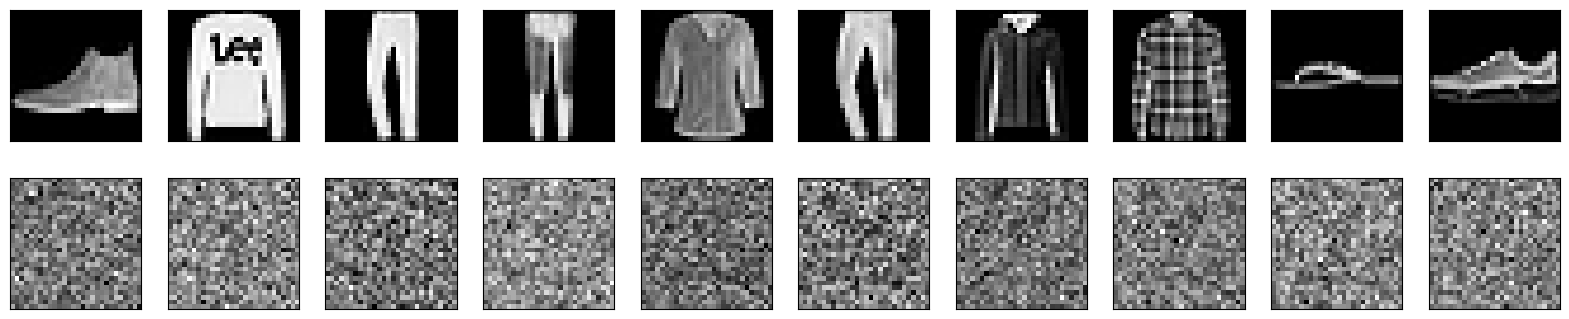

In [9]:
# Cell 7: Visualize Reconstructed Images from Basic VAE
def visualize_reconstructions(model, data_loader):
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            reconstructed, _, _ = model(data)
            break

    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20, 4))

    for images, row in zip([data, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

visualize_reconstructions(vae, test_loader)


In [10]:
# Cell 8: Define Encoder-Decoder as Encoder
class EncoderDecoderAsEncoder(nn.Module):
    def __init__(self):
        super(EncoderDecoderAsEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        mu = self.fc_mu(decoded)
        logvar = self.fc_logvar(decoded)
        return mu, logvar

class VAE_ED_Encoder(nn.Module):
    def __init__(self):
        super(VAE_ED_Encoder, self).__init__()
        self.encoder = EncoderDecoderAsEncoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [11]:
# Cell 9: Initialize and Train VAE with Encoder-Decoder as Encoder
vae_ed_encoder = VAE_ED_Encoder().to(device)
optimizer = optim.Adam(vae_ed_encoder.parameters(), lr=1e-3)

for epoch in range(1, num_epochs + 1):
    train(vae_ed_encoder, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

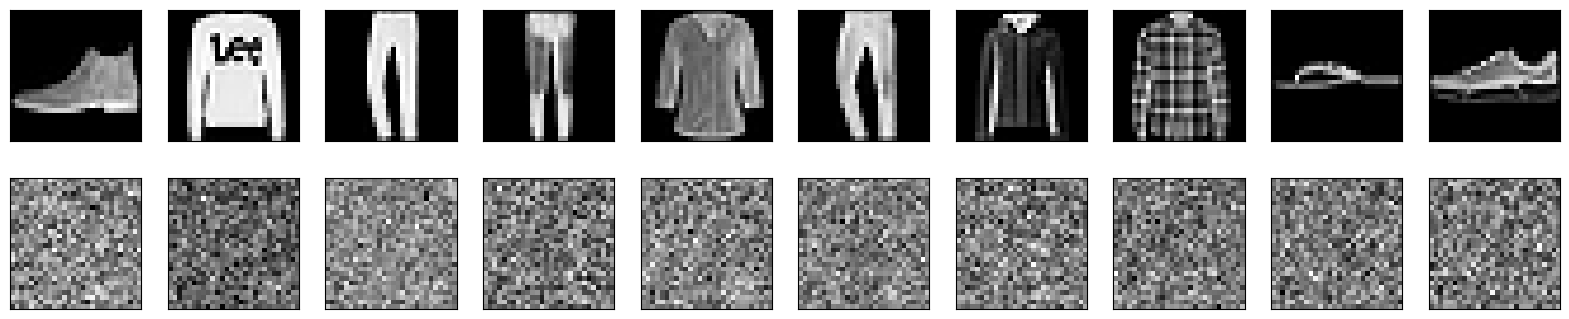

In [12]:
# Cell 10: Visualize Reconstructed Images from VAE with Encoder-Decoder as Encoder
visualize_reconstructions(vae_ed_encoder, test_loader)


In [15]:
# Cell 11: Define Encoder-Decoder as Decoder
class EncoderDecoderAsDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoderAsDecoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc31 = nn.Linear(200, 20)
        self.fc32 = nn.Linear(200, 20)

        self.fc4 = nn.Linear(20, 200)
        self.fc5 = nn.Linear(200, 400)
        self.fc6 = nn.Linear(400, 28*28)

        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h1 = nn.functional.relu(self.fc1(x.view(-1, 28*28)))
        h2 = nn.functional.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = nn.functional.relu(self.fc4(z))
        h4 = nn.functional.relu(self.fc5(h3))
        return torch.sigmoid(self.fc6(h4)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

class VAE_ED_Decoder(nn.Module):
    def __init__(self):
        super(VAE_ED_Decoder, self).__init__()
        self.encoder_decoder_as_decoder = EncoderDecoderAsDecoder()

    def forward(self, x):
        return self.encoder_decoder_as_decoder(x)


In [16]:
# Cell 12: Initialize and Train VAE with Encoder-Decoder as Decoder
vae_ed_decoder = VAE_ED_Decoder().to(device)
optimizer = optim.Adam(vae_ed_decoder.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(vae_ed_decoder, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

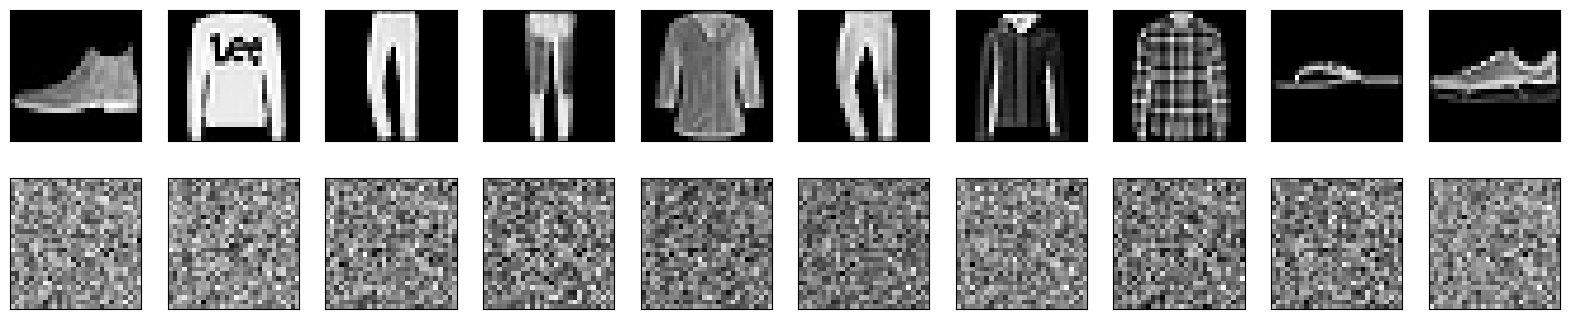

In [17]:
# Cell 13: Visualize Reconstructed Images from VAE with Encoder-Decoder as Decoder
visualize_reconstructions(vae_ed_decoder, test_loader)


In [18]:
# Cell 14: Define Encoder-Decoder for Both Encoder and Decoder
class EncoderDecoderAsBoth(nn.Module):
    def __init__(self):
        super(EncoderDecoderAsBoth, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        self.middle_encoder = nn.Sequential(
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(400, 20)
        self.fc_logvar = nn.Linear(400, 20)

        self.decoder = nn.Sequential(
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 400),
            nn.ReLU()
        )
        self.middle_decoder = nn.Sequential(
            nn.Linear(400, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = torch.flatten(x, start_dim=1)
        encoded = self.encoder(x)
        middle_encoded = self.middle_encoder(encoded)
        mu = self.fc_mu(middle_encoded)
        logvar = self.fc_logvar(middle_encoded)
        return mu, logvar

    def decode(self, z):
        decoded = self.decoder(z)
        reconstructed = self.middle_decoder(decoded)
        return reconstructed.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

class VAE_ED_Both(nn.Module):
    def __init__(self):
        super(VAE_ED_Both, self).__init__()
        self.encoder_decoder_both = EncoderDecoderAsBoth()

    def forward(self, x):
        return self.encoder_decoder_both(x)


In [19]:
# Cell 15: Initialize and Train VAE with Encoder-Decoder for Both Encoder and Decoder
vae_ed_both = VAE_ED_Both().to(device)
optimizer = optim.Adam(vae_ed_both.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(vae_ed_both, train_loader, optimizer, epoch)


Streaming output truncated to the last 5000 lines.
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 408:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 409:
data.shape: torch.Size([128, 1, 28, 28]), reconstructed_batch.shape: torch.Size([128, 1, 28, 28])
data.dtype: torch.float32, reconstructed_batch.dtype: torch.float32
RuntimeError during loss computation: all elements of target should be between 0 and 1
reconstructed_batch.shape: torch.Size([128, 1, 28, 28]), data.shape: torch.Size([128, 1, 28, 28])
Batch 410:
data.shape: torch.Size([128, 

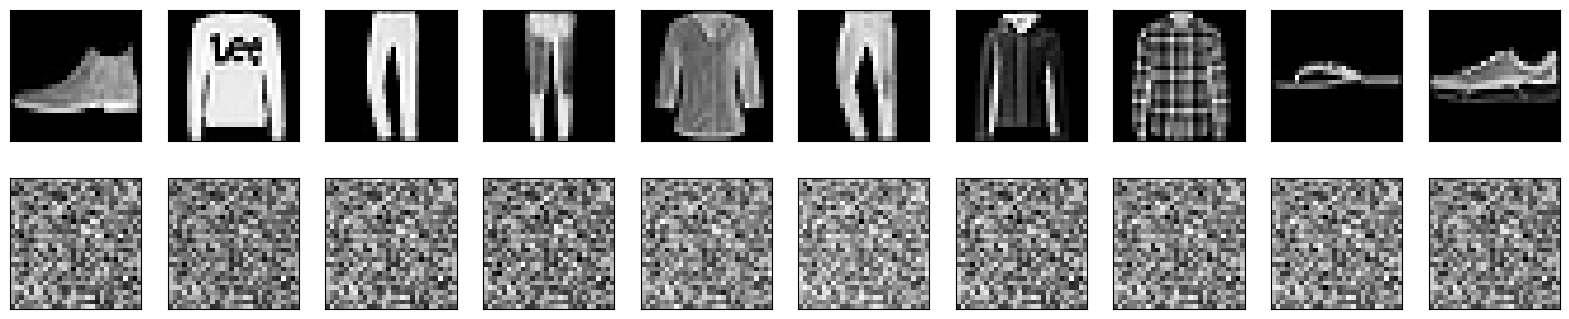

In [20]:
# Cell 16: Visualize Reconstructed Images from VAE with Encoder-Decoder for Both Encoder and Decoder
visualize_reconstructions(vae_ed_both, test_loader)


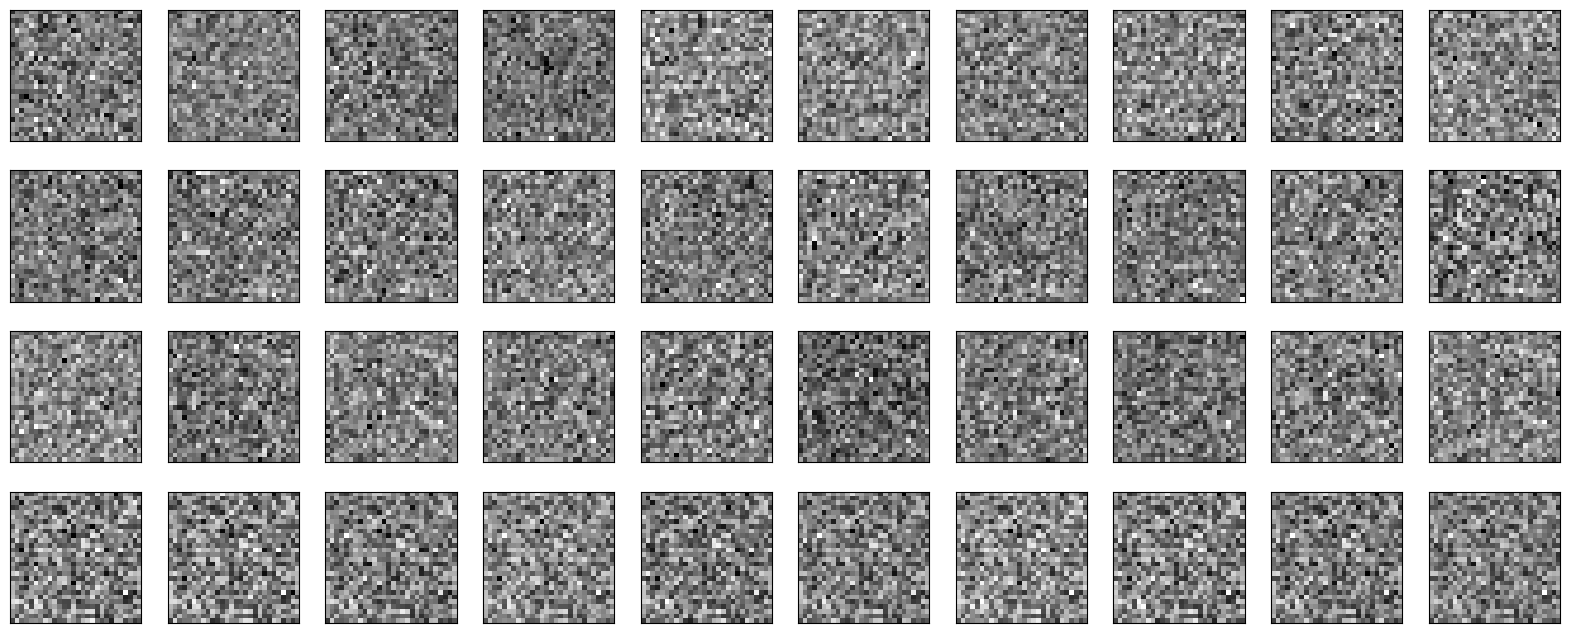

In [21]:
# Cell 17: Compare Results
def compare_vaes(vae_models, test_loader, device):
    fig, axes = plt.subplots(len(vae_models), 10, sharex=True, sharey=True, figsize=(20, 8))

    for i, model in enumerate(vae_models):
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(test_loader):
                data = data.to(device)
                reconstructed, _, _ = model(data)
                break

        for img, ax in zip(reconstructed, axes[i]):
            ax.imshow(img.cpu().numpy().squeeze(), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

vaes = [vae, vae_ed_encoder, vae_ed_decoder, vae_ed_both]
compare_vaes(vaes, test_loader, device)
